In [1]:
#installs
!pip install xlrd
!pip install uncertainties

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 8.8 MB/s eta 0:00:00


In [2]:
#imports
import pandas as pd
import numpy as np
from uncertainties import unumpy as unp
from uncertainties import ufloat
from uncertainties.umath import *
import math
import scipy as sc
import matplotlib.pyplot as plt
from scipy import optimize
from numpy import arange
from numpy.ma.core import tan
from scipy.optimize import curve_fit
import csv
from scipy.stats import norm
import matplotlib.ticker as ticker

In [3]:
#Definitionen
d_Kammer = ufloat(4.48, 0.01)*np.float_power(10,-2)
lam = 632.8e-9
p0 = 0.95032
glas1 = ufloat(0.32e-2, 0.01e-2)
glas2 = ufloat(0.31e-2, 0.01e-2)
glas3 = ufloat(0.0063, 0.0001)

In [4]:
#methods

def add_column_with_constant(array, constant_value):
    # Get the shape of the input array
    shape = array.shape
    
    # Create a column with constant values
    constant_column = np.full((shape[0], 1), constant_value)
    
    # Append the constant column to the input array
    new_array = np.concatenate((constant_column, array), axis=1)
    
    return new_array

def sinusfunct(x, a, b, phi, c):
    return (a*np.sin(b*x+phi) +c)

def logreg(x, a, b, c):
  return a/(1+b*np.exp(c*x))

def quadradic(x, a, b, c):
  return a*np.power(x,2) + b*x + c

def line(x, a, b):
  return a*x + b

def daten_fitten(funct, x_data, y_data, genauigkeit, p): #Step4/5
    #fiten
    pars, cov = curve_fit(f=funct, xdata=x_data, ydata=y_data, p0=p, bounds=[-np.inf, np.inf], maxfev=500000)
    # Get the standard deviations of the parameters (square roots of the diagonal of the covariance)
    stdevs = np.sqrt(np.diag(cov))
    print('Fitparameter')
    print(pars)
    print('zugehörige Uncertainty')
    print(stdevs)
    #datensets
    xfit = np.linspace(min(x_data), max(x_data), genauigkeit)
    yfit = funct(xfit, *pars)
    return pars, stdevs, xfit, yfit

def filter_array_lower_limit(array, filtervalue, index):
    # Get the second column of the input array
    second_column = array[:, index]
    
    # Find the indices where the values are greater than 10
    indices = np.where(second_column > filtervalue)
    
    # Filter the array based on the indices
    filtered_array = array[indices]
    
    return filtered_array

def filter_array_upper_limit(array, filtervalue, index):
    # Get the second column of the input array
    second_column = array[:, index]
    
    # Find the indices where the values are greater than 10
    indices = np.where(second_column < filtervalue)
    
    # Filter the array based on the indices
    filtered_array = array[indices]
    
    return filtered_array


In [5]:
#Daten einlesen
data = pd.read_excel('data.xlsx')

#converte dataframe to array
data = data.values

Schraube_array = data[:, :2]   # First two columns
Druck_array = data[:, 2:4]  # Columns 3 and 4
Winkel_array = data[:, 4:]   # Last two columns

nan_rows = np.isnan(Schraube_array).any(axis=1)
Schraube_array = Schraube_array[~nan_rows]
nan_rows = np.isnan(Druck_array).any(axis=1)
Druck_array = Druck_array[~nan_rows]
nan_rows = np.isnan(Winkel_array).any(axis=1)
Winkel_array = Winkel_array[~nan_rows]

Spiegel_array = Schraube_array[7:, :]
Schraube_array = Schraube_array[:7, :]
#print(Schraube_array)
#print(Spiegel_array)
#print(Druck_array)
#print(Winkel_array)

# A1
mean = np.mean(Schraube_array[:, 0])
standardabweichung = np.std(Schraube_array[:, 0])
A1_value = ufloat(mean, standardabweichung)
print(A1_value)
plus = ufloat(0, 0.5)
A1_value = A1_value + plus
print(A1_value)


9.64+/-0.26
9.6+/-0.6


Steigung: 2.8518+/-0.0011


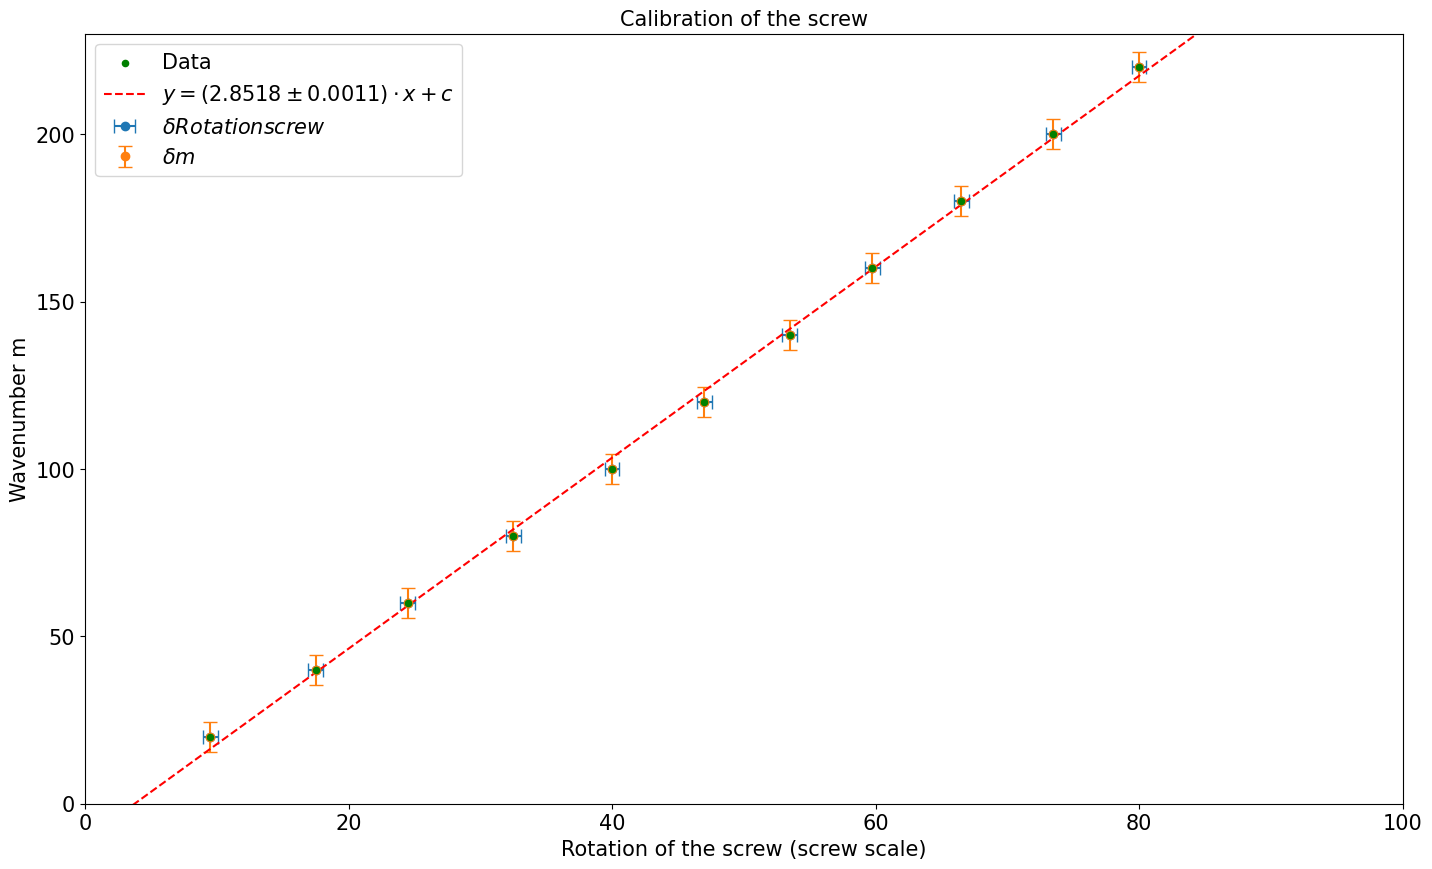

Länge:  (9.0232+/-0.0035)e-07


In [6]:
#A2
uncertainty_array = np.array([A1_value.std_dev, sqrt(20)])
uSpiegel_array = unp.uarray(Spiegel_array, uncertainty_array)

plt.subplots(1,1,figsize=(17, 10));

x = [float(i[0].nominal_value) for i in uSpiegel_array]
y = [float(i[1].nominal_value) for i in uSpiegel_array]

plt.scatter(x, y, label = 'Data', color='green', s=20, zorder= 5)

x_error = [float(i[0].std_dev) for i in uSpiegel_array]
y_error = [float(i[1].std_dev) for i in uSpiegel_array]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δRotationscrew$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δm$')

popt, pcov = sc.optimize.curve_fit(line, x, y)
a, b = popt
x_line = arange(-100, 300)
y_line = line(x_line, a, b)
perr = np.diag(pcov)
steigung = ufloat(popt[0], pcov[0][0])
Schnitt = ufloat(popt[1], pcov[1][1])

plt.plot(x_line, y_line, '--', color='red', label = r'$y = (%.4f \pm %.4f) \cdot x + c$'%(steigung.nominal_value, steigung.std_dev))
print('Steigung:', steigung)


# Add axis labels and a title
plt.xlabel(r'Rotation of the screw (screw scale)', fontsize=15)
plt.ylabel(r'Wavenumber m', fontsize=15)
plt.title('Calibration of the screw', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
plt.axis([0, 100, 0, 230]) #Achsenanpassung
plt.show()

l = steigung/2*lam
print('Länge: ', l)

Steigung: 0.000199712223+/-0.000000000011
0.999999533496+/-0.000000000004


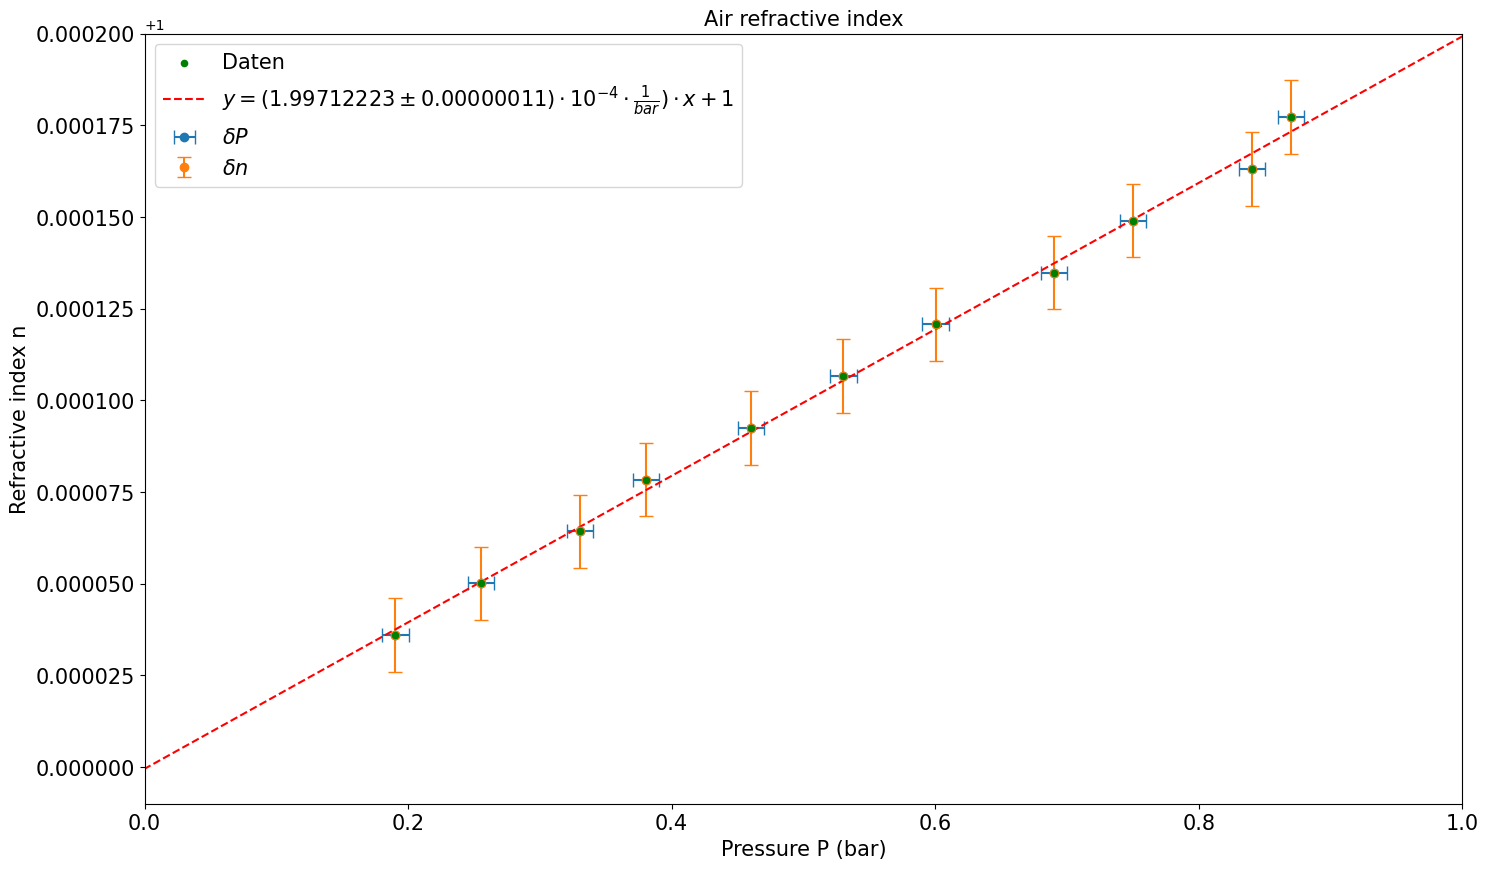

In [7]:
#A3
uncertainty_array = np.array([10, sqrt(2)])
uDruck_array = unp.uarray(Druck_array, uncertainty_array)

#calculate delta n
n_values = np.zeros(len(uDruck_array))
n_values = unp.uarray(n_values, 0)
for i in range(len(uDruck_array)):
  n_values[i] = uDruck_array[i, 1] * lam / (2*d_Kammer)

uDruck_array = np.column_stack((uDruck_array, n_values))

uDruck_array[:, 0] = uDruck_array[:, 0]/1000 + p0
uDruck_array[:, 2] = uDruck_array[:, 2] + 1 +0.000036


plt.subplots(1,1,figsize=(17, 10));

x = [float(i[0].nominal_value) for i in uDruck_array]
y = [float(i[2].nominal_value) for i in uDruck_array]

plt.scatter(x, y, label = 'Daten', color='green', s=20, zorder= 5)

x_error = [float(i[0].std_dev) for i in uDruck_array]
y_error = [float(i[2].std_dev) for i in uDruck_array]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δP$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δn$')

popt, pcov = sc.optimize.curve_fit(line, x, y)
a, b = popt
x_line = arange(-100, 300)
y_line = line(x_line, a, b)
perr = np.diag(pcov)
steigung = ufloat(popt[0], pcov[0][0])
Schnitt = ufloat(popt[1], pcov[1][1])

plt.plot(x_line, y_line, '--', color='red', label = r'$y = (%.8f \pm %.8f) \cdot 10^{-4} \cdot \frac{1}{bar}) \cdot x + 1$'%(steigung.nominal_value*np.power(10,4), steigung.std_dev*np.power(10,4)))
print('Steigung:', steigung)
print(Schnitt)


# Add axis labels and a title
plt.xlabel('Pressure P (bar)', fontsize=15)
plt.ylabel(r'Refractive index n', fontsize=15)
plt.title('Air refractive index', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
plt.axis([0, 1, 0.99999, 1.0002]) #Achsenanpassung
plt.show()

[[-0.17453292519943295+/-0.004363323129985824 109.0+/-10.44030650891055
  1.5610760777485622+/-0.09565287774452766]
 [-0.13962634015954636+/-0.004363323129985824 68.0+/-8.246211251235321
  1.5392865695361082+/-0.11401367827503349]
 [-0.10471975511965977+/-0.004363323129985824 41.0+/-6.4031242374328485
  1.6013754791817203+/-0.17115540251881373]
 [-0.06981317007977318+/-0.004363323129985824 20.0+/-4.47213595499958
  1.7011853478386356+/-0.3061619508143414]
 [-0.03490658503988659+/-0.004363323129985824 5.0+/-2.23606797749979
  1.7011853478386356+/-0.6114450619575549]
 [0.03490658503988659+/-0.004363323129985824 5.0+/-2.23606797749979
  1.7011853478386356+/-0.6114450619575549]
 [0.06981317007977318+/-0.004363323129985824 19.0+/-4.358898943540674
  1.6435632252490824+/-0.2768534656058796]
 [0.10471975511965977+/-0.004363323129985824 39.0+/-6.244997998398398
  1.5557373193805797+/-0.15667163062371328]
 [0.13962634015954636+/-0.004363323129985824 71.0+/-8.426149773176359
  1.5768019269789797

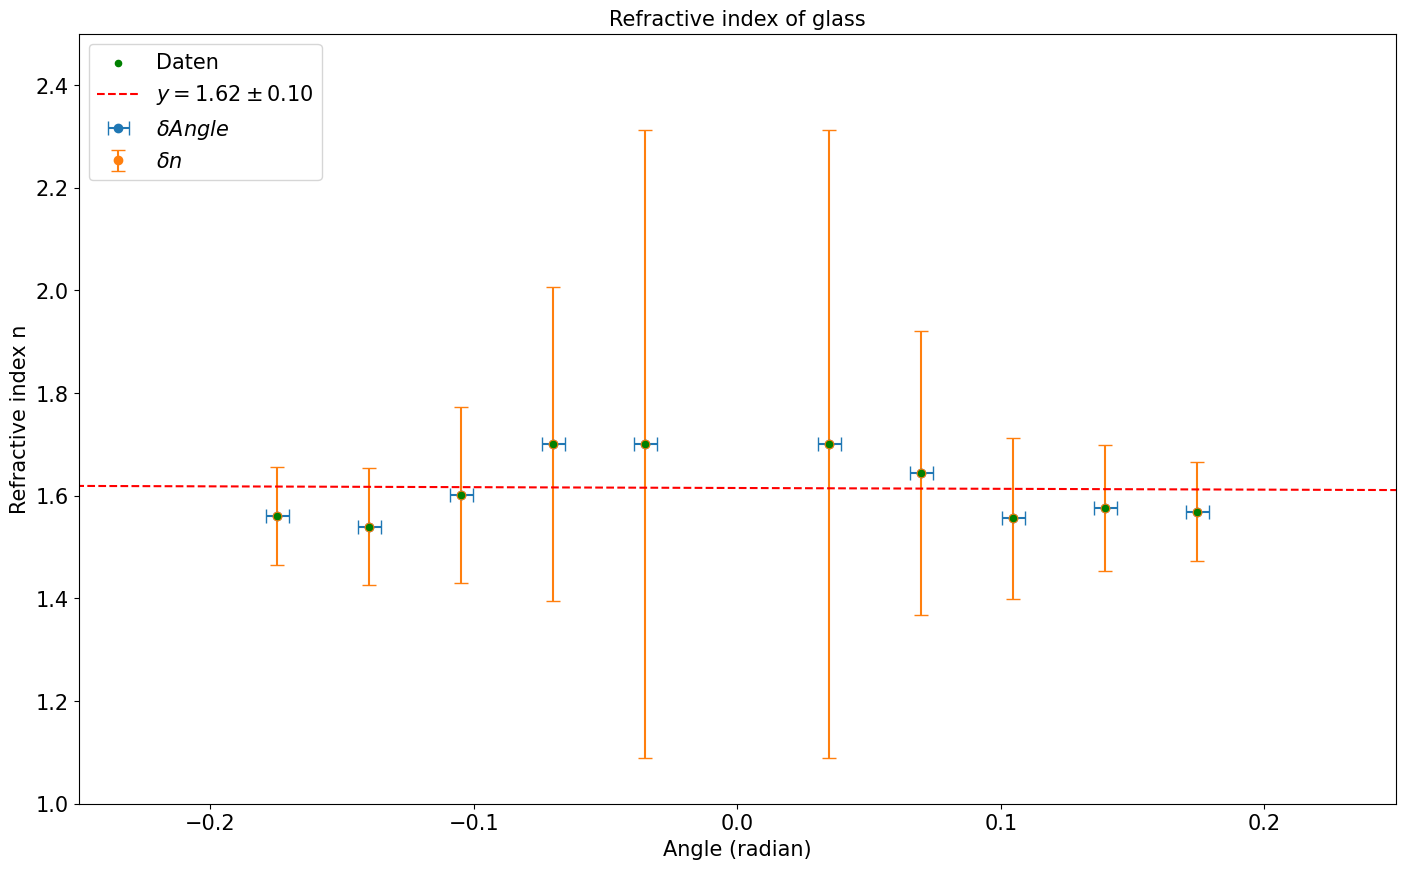

In [8]:
#A4


uncertainty_array = np.array([0.25, 0])
uWinkel_array = unp.uarray(Winkel_array, uncertainty_array)

uWinkel_array[:, 0] = uWinkel_array[:, 0]*2*np.pi/360
uWinkel_array[5,0] = ufloat(0.00000001,0.008726646259971648)

for i in range(len(uWinkel_array)):

  new = uWinkel_array[i, 1].nominal_value
  new2 = ufloat(new, np.sqrt(new))
  uWinkel_array[i, 1] = new2
#calculate delta n
n_values = np.zeros(len(uWinkel_array))
n_values = unp.uarray(n_values, 0)
for i in range(len(uWinkel_array)):
  n_values[i] = 1/(1-(uWinkel_array[i,1]*lam/(glas3*np.power(uWinkel_array[i,0], 2))))

uWinkel_array = np.column_stack((uWinkel_array, n_values))

uWinkel_array = np.delete(uWinkel_array, 5, axis=0)

print(uWinkel_array)
mean = np.mean(uWinkel_array[:, 2])
print(mean)


plt.subplots(1,1,figsize=(17, 10));

x = [float(i[0].nominal_value) for i in uWinkel_array]
y = [float(i[2].nominal_value) for i in uWinkel_array]

plt.scatter(x, y, label = 'Daten', color='green', s=20, zorder= 5)

x_error = [float(i[0].std_dev) for i in uWinkel_array]
y_error = [float(i[2].std_dev) for i in uWinkel_array]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δAngle$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δn$')

popt, pcov = sc.optimize.curve_fit(line, x, y)
a, b= popt
x_line = arange(-100, 300)
y_line = line(x_line, a, b)
perr = np.diag(pcov)
steigung = ufloat(popt[0], pcov[0][0])
Schnitt = ufloat(popt[1], pcov[1][1])

plt.plot(x_line, y_line, '--', color='red', label = r'$y = %.2f \pm %.2f$'%(mean.nominal_value, mean.std_dev))
print('Steigung:', steigung)


# Add axis labels and a title
plt.xlabel(r'Angle (radian)', fontsize=15)
plt.ylabel(r'Refractive index n', fontsize=15)
plt.title('Refractive index of glass', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
plt.axis([-0.25, 0.25, 1, 2.5]) #Achsenanpassung
plt.show()